<div style='background-image: url("../share/baku.jpg") ; padding: 0px ; background-size: cover ; border-radius: 15px ; height: 250px; background-position: 0% 80%'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.9) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.9) ; line-height: 100%">ObsPy Tutorial</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.7)">Downloading/Processing Exercise</div>
        </div>
    </div>
</div>
image: User:Abbaszade656 / Wikimedia Commons / <a href="http://creativecommons.org/licenses/by-sa/4.0/">CC-BY-SA-4.0</a>

## Workshop for the "Training in Network Management Systems and Analytical Tools for Seismic"
### Baku, October 2018

Seismo-Live: http://seismo-live.org

##### Authors:
* Lion Krischer ([@krischer](https://github.com/krischer))
* Tobias Megies ([@megies](https://github.com/megies))
---

![](images/obspy_logo_full_524x179px.png)

For the this exercise we will download some data from the Tohoku-Oki earthquake, cut out a certain time window around the first arrival and remove the instrument response from the data.

In [1]:
%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 12, 8

The first step is to download all the necessary information using the ObsPy FDSN client. **Learn to read the documentation!**

We need the following things:

1. Event information about the 2014 South Napa earthquake. Use the `get_events()` method of the client. A good provider of event data is the USGS.
2. Waveform information for a certain station. Choose your favorite one! If you have no preference, use `II.PFO` which is available for example from IRIS. Use the `get_waveforms()` method.
3. Download the associated station/instrument information with the `get_stations()` method.

In [2]:
import obspy
from obspy.clients.fdsn import Client

c_event = Client("USGS")

# Event time.
event_time = obspy.UTCDateTime("2014-08-24T10:20:44.0")

# Get the event information. The temporal and magnitude constraints make it unique
cat = c_event.get_events(starttime=event_time - 10, endtime=event_time + 10,
                         minmagnitude=6)
print(cat)

c = Client("IRIS")
# Download station information at the response level!
inv = c.get_stations(network="II", station="PFO", location="00", channel="BHZ",
                     starttime=event_time - 10 * 60, endtime=event_time + 30 * 60,
                     level="response")
print(inv)

# Download 3 component waveforms.
st = c.get_waveforms(network="II", station="PFO", location="00",
                     channel="BHZ", starttime=event_time - 10 * 60,
                     endtime=event_time + 30 * 60)
print(st)

1 Event(s) in Catalog:
2014-08-24T10:20:44.070000Z | +38.215, -122.312 | 6.02 mw | manual
Inventory created at 2017-09-15T19:49:54.000000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.27
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2014-08-24...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			II
		Stations (1):
			II.PFO (Pinon Flat, California, USA)
		Channels (1):
			II.PFO.00.BHZ
1 Trace(s) in Stream:
II.PFO.00.BHZ | 2014-08-24T10:10:44.019500Z - 2014-08-24T10:50:43.969500Z | 20.0 Hz, 48000 samples


Have a look at the just downloaded data.

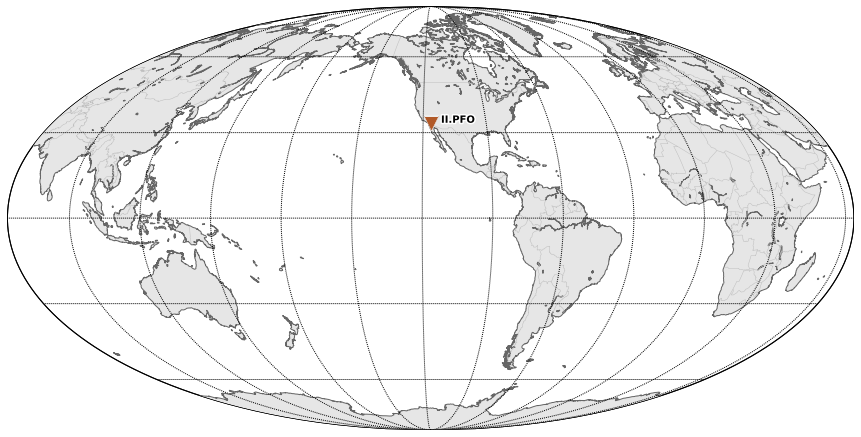

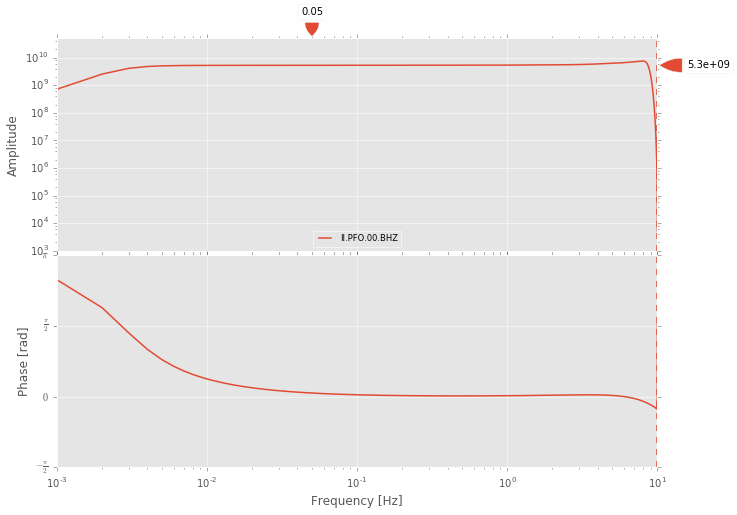

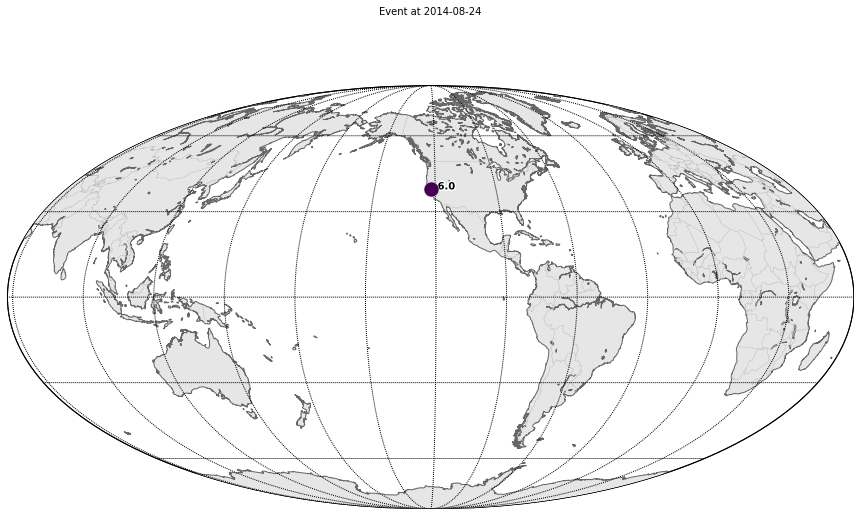

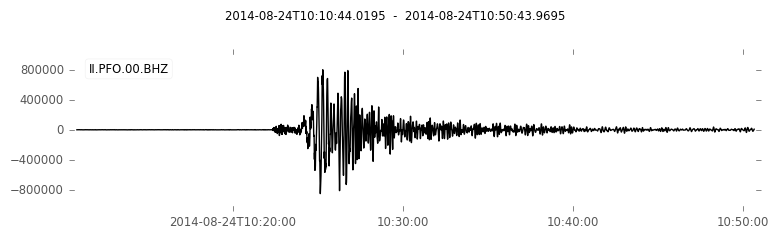

In [3]:
inv.plot()
inv.plot_response(0.001)
cat.plot()
st.plot()

## Exercise

The goal of this exercise is to cut the data from 1 minute before the first arrival to 5 minutes after it, and then remove the instrument response.


#### Step 1: Determine Coordinates of Station

In [4]:
coords = inv.get_coordinates("II.PFO.00.BHZ")
coords

{'elevation': 1280.0,
 'latitude': 33.6107,
 'local_depth': 5.3,
 'longitude': -116.4555}

#### Step 2: Determine Coordinates of Event

In [5]:
origin = cat[0].origins[0]
print(origin)

Origin
	        resource_id: ResourceIdentifier(id="quakeml:earthquake.usgs.gov/archive/product/origin/nc72282711/nc/1503942901517/product.xml")
	               time: UTCDateTime(2014, 8, 24, 10, 20, 44, 70000)
	          longitude: -122.3123333
	           latitude: 38.2151667
	              depth: 11120.0 [uncertainty=150.0]
	            quality: OriginQuality(used_phase_count=400, used_station_count=369, standard_error=0.18, azimuthal_gap=28.0, minimum_distance=0.03604)
	 origin_uncertainty: OriginUncertainty(horizontal_uncertainty=110.0, preferred_description='horizontal uncertainty')
	    evaluation_mode: 'manual'
	      creation_info: CreationInfo(agency_id='NC', creation_time=UTCDateTime(2017, 8, 28, 17, 55, 1, 517000), version='28')


#### Step 3: Calculate distance of event and station.

Use `obspy.geodetics.locations2degree`.

In [6]:
from obspy.geodetics import locations2degrees

distance = locations2degrees(origin.latitude, origin.longitude,
                             coords["latitude"], coords["longitude"])
print(distance)

6.607875295746713


#### Step 4: Calculate Theoretical Arrivals

```python
from obspy.taup import TauPyModel
m = TauPyModel(model="ak135")
arrivals = m.get_ray_paths(...)
arrivals.plot()
```

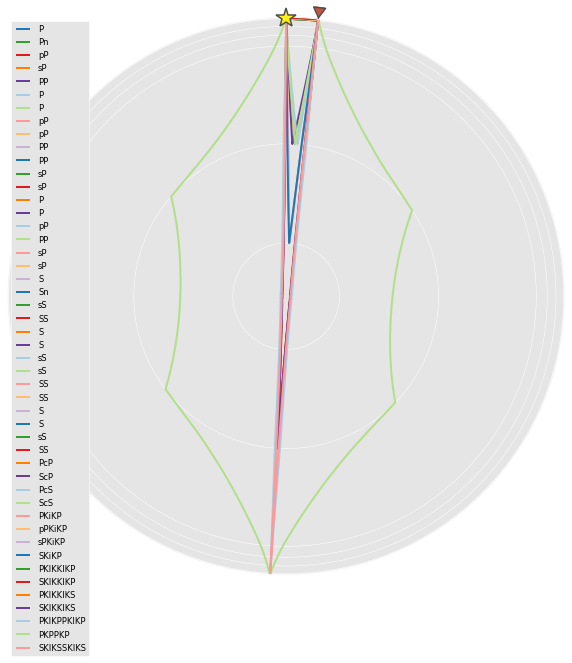

In [7]:
from obspy.taup import TauPyModel

m = TauPyModel(model="ak135")

arrivals = m.get_ray_paths(
    distance_in_degree=distance,
    source_depth_in_km=origin.depth / 1000.0)

arrivals.plot();

#### Step 5: Calculate absolute time of the first arrivals at the station

In [8]:
first_arrival = origin.time + arrivals[0].time

print(first_arrival)

2014-08-24T10:22:21.096348Z


#### Step 6:  Cut to 1 minute before and 5 minutes after the first arrival

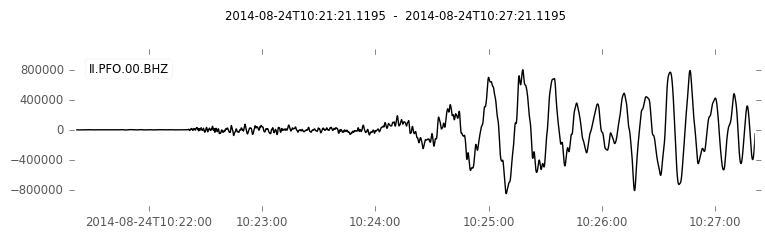

In [9]:
st.trim(first_arrival - 60, first_arrival + 300)
st.plot();

#### Step 7: Remove the instrument response

```python
st.remove_response(inventory=inv, pre_filt=...)
```

![taper](images/cos_taper.png)

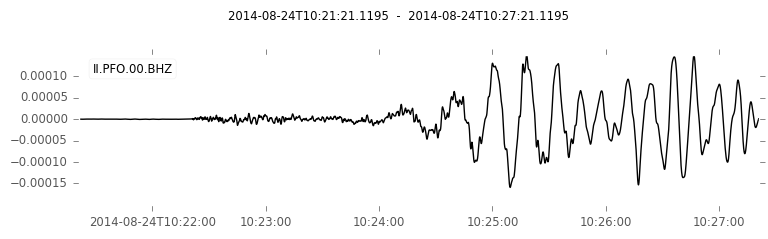

In [10]:
st.remove_response(inventory=inv, 
                   pre_filt=(1.0 / 100.0, 1.0 / 50.0, 10.0, 20.0),
                   output="VEL")
st.plot()

## Bonus: Interactive IPython widgets

In [15]:
from ipywidgets import interact
from obspy.taup import TauPyModel

m = TauPyModel("ak135")

def plot_raypaths(distance, depth, wavetype):
    try:
        plt.close()
    except:
        pass
    if wavetype == "ttall":
        phases = ["ttall"]
    elif wavetype == "diff":
        phases = ["Pdiff", "pPdiff"]
    m.get_ray_paths(distance_in_degree=distance,
                    source_depth_in_km=depth,
                    phase_list=phases).plot();
    
interact(plot_raypaths, distance=(1, 180),
         depth=(0, 700), wavetype=["ttall", "diff"]);

A Jupyter Widget